<a href="https://colab.research.google.com/github/orekhovsky/GenAI-mini-projects/blob/main/RAG%20model%20comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Без векторной бд

In [ ]:
pip install gigachat transformers rouge-score -q

In [ ]:
pip install -U langchain-community -q

In [ ]:
import pandas as pd
import ast
from langchain.chat_models.gigachat import GigaChat
from google.colab import userdata
import nltk
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import requests
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")

# Преобразование чтобы правильно считать строку со списком релевантных id из корпуса текстов
df_test['relevant_passage_ids'] = df_test['relevant_passage_ids'].apply(ast.literal_eval)

# Функция для извленения чанков и формирования контекста для подачи в llm
def perform_retrieval(question, df, df_test):

    matching_rows = df_test[df_test['question'] == question]
    if matching_rows.empty:
        raise ValueError(f"Question '{question}' not found in df_test.")

    question_index = matching_rows.index[0]

    # Получение релевантных чанков из корпуса текстов
    relevant_passage_ids = df_test.loc[question_index, 'relevant_passage_ids']
    relevant_passages = [df.loc[i, 'passage'] for i in relevant_passage_ids]

    # Формируем контекст
    context = " ".join(relevant_passages)

    return context


## Оценка метрик

In [ ]:

nltk.download('wordnet')
nltk.download('omw-1.4')

def add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df):
    """
    Вычисляет метрики BLEU, METEOR и ROUGE для данной модели, а затем добавляет их в датафрейм.

    Args:
        model_name (str): Название модели.
        true_answer (str): Истинный ответ.
        response (str): Ответ модели.
        metrics_df (pd.DataFrame): Датафрейм с метриками.

    Returns:
        pd.DataFrame: Обновленный датафрейм с добавленными метриками.
    """
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, response)

    # BLEU
    true_tokens = true_answer.split()
    response_tokens = response.split()
    smooth_fn = SmoothingFunction().method1
    bleu_score = sentence_bleu([true_tokens], response_tokens, smoothing_function=smooth_fn)

    # METEOR
    meteor = meteor_score([true_answer.split()], response.split())

    # Создание строки с метриками
    new_row = pd.DataFrame([{
        "Model": model_name,
        "BLEU": bleu_score,
        "METEOR": meteor,
        "ROUGE-1": rouge_scores['rouge1'].fmeasure,
        "ROUGE-2": rouge_scores['rouge2'].fmeasure,
        "ROUGE-L": rouge_scores['rougeL'].fmeasure
    }])

    # Добавление строки в датафрейм
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    return metrics_df

# Пример использования
columns = ["Model", "BLEU", "METEOR", "ROUGE-1", "ROUGE-2", "ROUGE-L"]
metrics_df = pd.DataFrame(columns=columns)
true_answer = df_test['answer'][0]
# # Пример данных
# model_name = "Llama 3.2-1b"
# true_answer = df_test['answer'][0]
# response = "Generated response by the model"

# # Обновление датафрейма
# metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

# # Просмотр датафрейма
# print(metrics_df)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Сравниваемые модели

### Гигачат

In [ ]:
# Авторизация через токен
auth = userdata.get('SBER_AUTH')

# Инициализация модели GigaChat
llm = GigaChat(
    credentials=auth,
    model='GigaChat:latest',
    verify_ssl_certs=False,
    profanity_check=False
)

# Пайплайн для RAG
def perform_rag_pipeline(question, df, df_test, llm):
    # Шаг 1: Извлекаем контекст из корпуса на основе вопроса
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Входные данные для модели
    input_text = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""

    # Шаг 3: Генерируем ответ
    response = llm.predict(input_text)

    return response

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, llm)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Gigachat"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)


<ipython-input-26-d978d5c8627d>:5: LangChainDeprecationWarning: The class `GigaChat` was deprecated in LangChain 0.3.5 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-gigachat package and should be used instead. To use it run `pip install -U :class:`~langchain-gigachat` and import as `from :class:`~langchain_gigachat import GigaChat``.
  llm = GigaChat(
<ipython-input-26-d978d5c8627d>:26: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm.predict(input_text)


Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: Hirschsprung disease (HSCR) is considered a **multifactorial** disorder rather than a Mendelian inherited disorder. This means that it results from the combined effects of multiple genetic factors and environmental influences, rather than being caused by mutations in a single gene.

The study cited mentions that HSCR shows "complex patterns of inheritance," including both dominant and recessive patterns, as well as polygenic inheritance, which further supports the classification as a multifactorial disorder.


<ipython-input-25-874a1bcc5702>:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


In [ ]:
from rouge_score import rouge_scorer
true_answer = df_test['answer'][0]

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(true_answer, response)

# Метрики (не очень, но по сути верно)
print("ROUGE-1:", scores['rouge1'])
print("ROUGE-2:", scores['rouge2'])
print("ROUGE-L:", scores['rougeL'])


ROUGE-1: Score(precision=0.26506024096385544, recall=0.36065573770491804, fmeasure=0.3055555555555556)
ROUGE-2: Score(precision=0.06097560975609756, recall=0.08333333333333333, fmeasure=0.07042253521126761)
ROUGE-L: Score(precision=0.10843373493975904, recall=0.14754098360655737, fmeasure=0.125)


### gpt-4o-mini

In [ ]:
response ="Hirschsprung disease (HSCR) is a complex disorder with both Mendelian and multifactorial aspects. While some forms of the disease, particularly the syndromic and familial types, follow Mendelian inheritance patterns (autosomal dominant, recessive, and polygenic), the more common non-syndromic forms exhibit non-Mendelian inheritance with variable expression and incomplete penetrance. Genetic studies suggest that multiple loci and genetic interactions contribute to the disease, making it a multifactorial disorder."

model_name = "gpt-4o-mini"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

### Llama 3.2 1B Instruct

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "meta-llama/llama-3.2-1b-instruct",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Llama 3.2 1B Instruct"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)


Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: According to the text, Hirschsprung disease is a multifactorial disorder. It is characterized by the absence of ganglion cells in the gastrointestinal tract, and genetic studies have identified multiple genes and loci that contribute to its susceptibility. The text states that the majority of known genetic sites relate to the main susceptibility pathways (RET and EDNRB), and that non-syndromic non-familial, short-segment HSCR appears to represent a non-Mendelian condition with variable expression and sex-dependent penetrance. Therefore, the answer is that Hirschsprung disease is a multifactorial disorder.


### "deepseek/deepseek-chat"

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "deepseek/deepseek-chat",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "DeepSeek V3"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)


Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: Hirschsprung disease (HSCR) is described as a **multifactorial disorder** rather than a purely Mendelian one. While certain syndromic and familial forms of HSCR can exhibit Mendelian inheritance patterns (autosomal dominant, recessive, or polygenic), the non-syndromic, sporadic, and short-segment forms of HSCR are characterized by complex inheritance involving multiple loci, variable expression, and incomplete penetrance. The involvement of modifier genes and non-coding variations further supports the multifactorial nature of the disease.


### Qwen: QvQ 72B Preview

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "qwen/qvq-72b-preview",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Qwen: QvQ 72B Preview"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: So I've been reading about Hirschsprung disease, and I'm trying to understand whether it's a Mendelian disorder or a multifactorial one. From what I can gather, Hirschsprung disease, or HSCR, is a condition where there are missing nerve cells in parts of the large intestine, which can cause problems with passing stool.

First off, I know that Mendelian disorders follow straightforward patterns of inheritance, like dominant or recessive traits passed from parents to offspring. Multifactorial disorders, on the other hand, are influenced by multiple genes and often environmental factors, making their inheritance more complex and less predictable.

Looking at the context provided, there's a lot of information about the genetics of Hirschsprung disease. It mentions that the major gene involved is RET, which encodes a receptor tyrosine kinase. There are studies involving European and Chinese populations that 

### Google: Gemini 2.0 Flash Thinking Experimental (free)

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "google/gemini-2.0-flash-thinking-exp:free",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Google: Gemini 2.0 Flash Thinking Experimental (free)"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: The user is asking whether Hirschsprung disease is a Mendelian or a multifactorial disorder. I need to look for information in the text that describes the inheritance pattern of the disease.

The text mentions "non-Mendelian inheritance of sporadic non-syndromic Hirschsprung's disease", "Syndromic and familial forms, on the other hand, have complex patterns of inheritance and being reported as autosomal dominant, recessive and polygenic patterns of inheritance", and that "HSCR has become a model for a complex oligo-/polygenic disorder".The text states that the non-Mendelian inheritance of sporadic non-syndromic Hirschsprung's disease is complex. It also mentions that syndromic and familial forms have complex patterns of inheritance, including autosomal dominant, recessive, and polygenic patterns. The text also refers to HSCR as a model for a complex oligo-/polygenic disorder.

Therefore, Hirschsprung di

### xAI: Grok 2 Vision 1212

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "x-ai/grok-2-1212",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "xAI: Grok 2 Vision 1212"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: No content found


### gpt-4o-2024-11-20

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "openai/gpt-4o-2024-11-20",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "gpt-4o-2024-11-20"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: No content found


### Sao10K: Llama 3.3 Euryale 70B20

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "sao10k/l3.3-euryale-70b",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Sao10K: Llama 3.3 Euryale 70B"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: Hirschsprung disease is a complex oligo-/polygenic disorder, which indicates both Mendelian and multifactorial inheritance patterns depending on the form of the disease (syndromic vs. non-syndromic, familial vs. non-familial, short-segment vs. long-segment). However, overall, it is more multifactorial due to incomplete penetrance, variable expressivity, and evidence of multiple genetic and possibly environmental factors contributing to its expression.


In [ ]:
metrics_df

,Model,BLEU,METEOR,ROUGE-1,ROUGE-2,ROUGE-L
0,Gigachat,0.012220,0.184190,0.257576,0.076923,0.136364
1,gpt-4o-mini,0.014081,0.235693,0.341085,0.110236,0.217054
2,Llama 3.2 1B Instruct,0.010541,0.234707,0.344371,0.107383,0.198675
3,DeepSeek V3,0.012850,0.232019,0.432836,0.106061,0.208955
4,Qwen: QvQ 72B Preview,0.011957,0.177737,0.124077,0.035556,0.076809
5,Google: Gemini 2.0 Flash Thinking Experimental...,0.051784,0.265432,0.317308,0.135922,0.230769
7,xAI: Grok 2 Vision 1212,0.000000,0.000000,0.000000,0.000000,0.000000
9,gpt-4o-2024-11-20,0.000000,0.000000,0.000000,0.000000,0.000000
10,Sao10K: Llama 3.3 Euryale 70B,0.012645,0.171514,0.327869,0.066667,0.180328


## Визуализация сравнений

<Figure size 1200x800 with 0 Axes>

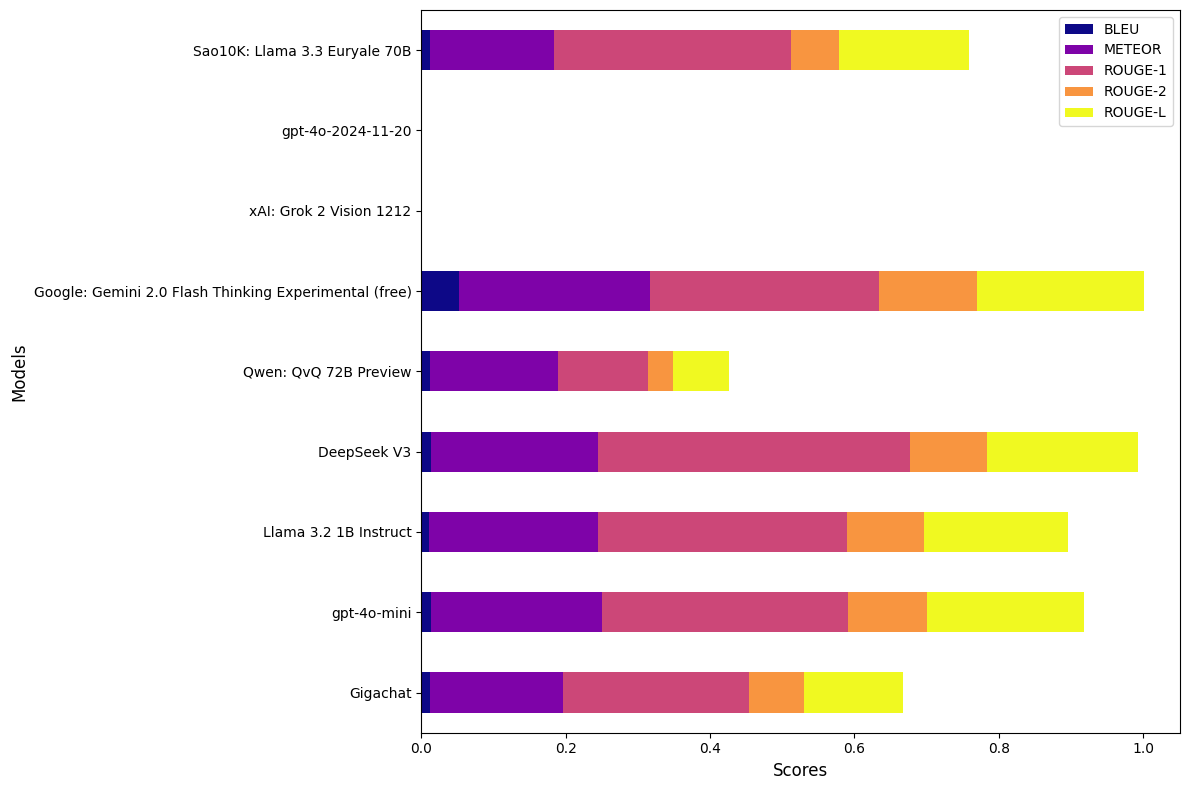

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = metrics_df
plt.figure(figsize=(12, 8))
df.set_index('Model').plot(kind='barh', stacked=True, figsize=(12, 8), colormap='plasma')

plt.xlabel('Scores', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.tight_layout()

plt.show()


# С векторной БД

In [2]:
pip install faiss-gpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.4 MB/s eta 0:00:00


In [3]:
pip install faiss-cpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 42.0 MB/s eta 0:00:00


In [4]:
pip install -U langchain-community rouge-score hnswlib -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.4 MB/s eta 0:00:00


In [5]:
import faiss  # Импорт библиотеки Faiss
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import requests
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from google.colab import userdata

In [5]:
# Загрузка данных
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
# Инициализация OpenRouter API
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

def query_openrouter(model, prompt):
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        data=json.dumps(data)
    )
    if response.status_code == 200:
        data = response.json()
        return data.get("choices", [{}])[0].get("message", {}).get("content", "No content returned")
    else:
        raise ValueError(f"Error {response.status_code}: {response.text}")


# Подготовка векторной базы данных Faiss
def create_faiss_index(corpus):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=768)
    vectors = vectorizer.fit_transform(corpus).toarray()
    index = faiss.IndexFlatL2(vectors.shape[1])  # Создание векторного индекса
    index.add(np.array(vectors, dtype=np.float32))  # Добавление векторов в индекс
    return index, vectorizer

faiss_index, vectorizer = create_faiss_index(df["passage"])

# Функция для извлечения релевантных документов
def retrieve_documents(query, index, vectorizer, k=5):
    query_vector = vectorizer.transform([query]).toarray().astype(np.float32)
    distances, indices = index.search(query_vector, k)
    return [df.iloc[i]["passage"] for i in indices[0]]

# Функция RAG
def perform_rag(question, model="deepseek/deepseek-chat", k=5):
    # Шаг 1: Ретривинг документов
    retrieved_docs = retrieve_documents(question, faiss_index, vectorizer, k)
    context = " ".join(retrieved_docs)

    # Шаг 2: Генерация ответа
    prompt = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Сравнение метрик
def evaluate_responses(true_answer, generated_answer):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, generated_answer)

    # BLEU
    smooth_fn = SmoothingFunction().method1
    true_tokens = true_answer.split()
    generated_tokens = generated_answer.split()
    bleu = sentence_bleu([true_tokens], generated_tokens, smoothing_function=smooth_fn)

    # METEOR
    meteor = meteor_score([true_tokens], generated_tokens)

    return {
        "ROUGE-1": rouge_scores["rouge1"].fmeasure,
        "ROUGE-2": rouge_scores["rouge2"].fmeasure,
        "ROUGE-L": rouge_scores["rougeL"].fmeasure,
        "BLEU": bleu,
        "METEOR": meteor
    }

# Основной пайплайн: проверяем только первые три вопроса
results = []
for i, row in df_test.head(3).iterrows():  # Используем .head(3) для первых трёх строк
    question = row["question"]
    true_answer = row["answer"]

    # Без RAG
    prompt_without_rag = f"""
    Answer the user's question.
    Question: {question}
    Answer:"""
    response_without_rag = query_openrouter("deepseek/deepseek-chat", prompt_without_rag)

    # С RAG
    response_with_rag = perform_rag(question)

    # Оценка
    metrics_without_rag = evaluate_responses(true_answer, response_without_rag)
    metrics_with_rag = evaluate_responses(true_answer, response_with_rag)

    results.append({
        "Question": question,
        "True Answer": true_answer,
        "Response without RAG": response_without_rag,
        "Response with RAG": response_with_rag,
        "Metrics without RAG": metrics_without_rag,
        "Metrics with RAG": metrics_with_rag
    })

# Создание DataFrame для визуализации
results_df = pd.DataFrame(results)
print(results_df)
query_openrouter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                            Question  \
0  Is Hirschsprung disease a mendelian or a multi...   
1  List signaling molecules (ligands) that intera...   
2                   Is the protein Papilin secreted?   

                                         True Answer  \
0  Coding sequence mutations in RET, GDNF, EDNRB,...   
1  The 7 known EGFR ligands  are: epidermal growt...   
2                Yes,  papilin is a secreted protein   

                                Response without RAG  \
0  Hirschsprung disease (HSCR) is primarily consi...   
1  The epidermal growth factor receptor (EGFR) in...   
2  As of the current scientific knowledge, there ...   

                                   Response with RAG  \
0  Hirschsprung disease is described as a heterog...   
1  Based on the context provided, the signaling m...   
2  The context does not provide any information a...   

                                 Metrics without RAG  \
0  {'ROUGE-1': 0.2635658914728682, 'ROUGE-2'

<function __main__.query_openrouter(model, prompt)>

In [ ]:
results_df

,Question,True Answer,Response without RAG,Response with RAG,Metrics without RAG,Metrics with RAG
0,Is Hirschsprung disease a mendelian or a multi...,"Coding sequence mutations in RET, GDNF, EDNRB,...",Hirschsprung disease (HSCR) is primarily consi...,Hirschsprung disease is described as a heterog...,"{'ROUGE-1': 0.2635658914728682, 'ROUGE-2': 0.0...","{'ROUGE-1': 0.2958579881656805, 'ROUGE-2': 0.0..."
1,List signaling molecules (ligands) that intera...,The 7 known EGFR ligands are: epidermal growt...,The epidermal growth factor receptor (EGFR) in...,"Based on the context provided, the signaling m...","{'ROUGE-1': 0.4716981132075472, 'ROUGE-2': 0.2...","{'ROUGE-1': 0.17964071856287425, 'ROUGE-2': 0...."
2,Is the protein Papilin secreted?,"Yes, papilin is a secreted protein","As of the current scientific knowledge, there ...",The context does not provide any information a...,"{'ROUGE-1': 0.10101010101010101, 'ROUGE-2': 0....","{'ROUGE-1': 0.24242424242424243, 'ROUGE-2': 0...."


In [6]:
import faiss
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import requests
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from google.colab import userdata
import nltk

# Загрузка необходимых ресурсов
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# Загрузка данных
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")

# Инициализация OpenRouter API
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

def query_openrouter(model, prompt):
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        data=json.dumps(data)
    )
    if response.status_code == 200:
        data = response.json()
        return data.get("choices", [{}])[0].get("message", {}).get("content", "No content returned")
    else:
        raise ValueError(f"Error {response.status_code}: {response.text}")

# Подготовка векторной базы данных Faiss
def create_faiss_index(corpus):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=768)
    vectors = vectorizer.fit_transform(corpus).toarray()
    index = faiss.IndexFlatL2(vectors.shape[1])  # Создание векторного индекса
    index.add(np.array(vectors, dtype=np.float32))  # Добавление векторов в индекс
    return index, vectorizer

faiss_index, vectorizer = create_faiss_index(df["passage"])

# Функция для извлечения релевантных документов
def retrieve_documents(query, index, vectorizer, k=5):
    query_vector = vectorizer.transform([query]).toarray().astype(np.float32)
    distances, indices = index.search(query_vector, k)
    return [df.iloc[i]["passage"] for i in indices[0]]

# Функция RAG
def perform_rag(question, index, vectorizer, model="deepseek/deepseek-chat", k=5):
    # Шаг 1: Ретривинг документов
    retrieved_docs = retrieve_documents(question, index, vectorizer, k)
    context = " ".join(retrieved_docs)

    # Шаг 2: Генерация ответа
    prompt = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Сравнение метрик
def evaluate_responses(true_answer, generated_answer):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, generated_answer)

    # BLEU
    smooth_fn = SmoothingFunction().method1
    true_tokens = true_answer.split()
    generated_tokens = generated_answer.split()
    bleu = sentence_bleu([true_tokens], generated_tokens, smoothing_function=smooth_fn)

    # METEOR
    meteor = meteor_score([true_tokens], generated_tokens)

    return {
        "ROUGE-1": rouge_scores["rouge1"].fmeasure,
        "ROUGE-2": rouge_scores["rouge2"].fmeasure,
        "ROUGE-L": rouge_scores["rougeL"].fmeasure,
        "BLEU": bleu,
        "METEOR": meteor
    }

# Основной пайплайн: проверяем первые 10 вопросов
results = []
for i, row in df_test.head(10).iterrows():
    question = row["question"]
    true_answer = row["answer"]

    # С RAG
    response_with_rag = perform_rag(question, faiss_index, vectorizer)

    # Оценка
    metrics_with_rag = evaluate_responses(true_answer, response_with_rag)
    results.append(metrics_with_rag)

# Средние значения по метрикам
avg_metrics = {metric: np.mean([res[metric] for res in results]) for metric in results[0].keys()}
avg_metrics["Vector Store"] = "Faiss"

# Создание итогового DataFrame
final_df = pd.DataFrame([avg_metrics])

# Упорядочивание столбцов
cols = ["Vector Store"] + [col for col in final_df.columns if col != "Vector Store"]
final_df = final_df[cols]

print(final_df)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  Vector Store   ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR
0        Faiss  0.174695  0.065575  0.148203  0.025629  0.155393


In [7]:
# Функция генерации без RAG
def perform_without_rag(question, model="deepseek/deepseek-chat"):
    prompt = f"""
    Answer the user's question directly based on your knowledge.
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Сравнение метрик (функция уже определена ранее)
# def evaluate_responses(true_answer, generated_answer): ...

# Основной цикл: проверяем те же первые 10 вопросов для подхода без RAG
results_without_rag = []

for i, row in df_test.head(10).iterrows():
    question = row["question"]
    true_answer = row["answer"]

    # Генерация ответа без RAG
    response_without_rag = perform_without_rag(question)

    # Оценка метрик
    metrics_without_rag = evaluate_responses(true_answer, response_without_rag)
    results_without_rag.append(metrics_without_rag)

# Средние значения по метрикам для без RAG
avg_metrics_without_rag = {metric: np.mean([res[metric] for res in results_without_rag]) for metric in results_without_rag[0].keys()}
avg_metrics_without_rag["Vector Store"] = "Without RAG"

# Преобразование в строку DataFrame
new_row = pd.DataFrame([avg_metrics_without_rag])

# Добавление новой строки к существующему DataFrame
final_df = pd.concat([final_df, new_row], ignore_index=True)

# Упорядочивание столбцов
cols = ["Vector Store"] + [col for col in final_df.columns if col != "Vector Store"]
final_df = final_df[cols]

# Вывод обновленного DataFrame
print(final_df)


  Vector Store   ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR
0        Faiss  0.174695  0.065575  0.148203  0.025629  0.155393
1  Without RAG  0.265239  0.114615  0.204112  0.015117  0.208108


In [15]:
import hnswlib

# Создание индекса HNSWlib
def create_hnsw_index(corpus, dim=768, space="l2"):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=dim)
    vectors = vectorizer.fit_transform(corpus).toarray()

    index = hnswlib.Index(space=space, dim=dim)
    index.init_index(max_elements=len(vectors), ef_construction=200, M=16)
    index.add_items(vectors)

    return index, vectorizer

hnsw_index, vectorizer = create_hnsw_index(df["passage"])

def retrieve_documents_hnsw(query, index, vectorizer, k=5):
    query_vector = vectorizer.transform([query]).toarray()[0]
    labels, _ = index.knn_query(query_vector, k=k)

    # Приводим индексы к целым числам
    labels = labels[0].astype(int)

    # Проверяем, что df — это DataFrame и столбец "passage" существует
    assert isinstance(df, pd.DataFrame), "df должен быть pandas DataFrame"
    assert "passage" in df.columns, "Столбец 'passage' не найден в DataFrame"

    # Извлекаем документы
    return [df.iloc[i]["passage"] for i in labels]

# RAG с HNSWlib
def perform_rag_hnsw(question, index, vectorizer, model="deepseek/deepseek-chat", k=5):
    retrieved_docs = retrieve_documents_hnsw(question, index, vectorizer, k)
    context = " ".join(retrieved_docs)
    prompt = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Подготовка данных и расчет метрик для HNSWlib
results_hnsw = []
for i, row in df_test.head(10).iterrows():
    question = row["question"]
    true_answer = row["answer"]
    response_with_rag_hnsw = perform_rag_hnsw(question, hnsw_index, vectorizer)
    metrics_with_rag_hnsw = evaluate_responses(true_answer, response_with_rag_hnsw)
    results_hnsw.append(metrics_with_rag_hnsw)

# Усреднение метрик
avg_metrics_hnsw = pd.DataFrame(results_hnsw).mean().to_dict()
avg_metrics_hnsw["Vector Store"] = "HNSWlib"

# Добавление строки к существующему DataFrame
new_row_hnsw = pd.DataFrame([avg_metrics_hnsw])
final_df = pd.concat([final_df, new_row_hnsw], ignore_index=True)

print(final_df)



  Vector Store   ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR
0        Faiss  0.174695  0.065575  0.148203  0.025629  0.155393
1  Without RAG  0.265239  0.114615  0.204112  0.015117  0.208108
2      HNSWlib  0.193787  0.073192  0.168525  0.017429  0.174551
